In [1]:
import os
os.environ["CDF_LIB"] = 'c:\cdf_distribution\cdf38_0-dist'
#import spacepy.toolbox
#spacepy.toolbox.update(leapsecs=True)
from spacepy import pycdf
import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

import SEMP

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
fname = '../../testdata/psp_fld_l2_rfs_hfr_20190409_v01.cdf'

In [4]:
import psp_dataprep

In [5]:
year = "2019"    ## must be in YYYY format 
month = "04"     ## Must be in MM format
day = "09"       ## Must be in DD format    
t0 = datetime.datetime(int(year),int(month),int(day))

# hfr
my_fileh12 = psp_dataprep.fnames("hfr",year,month,day,
"V1V2",dirdata='../../testdata/')
my_fileh34 = psp_dataprep.fnames("hfr",year,month,day,
"V3V4",dirdata='../../testdata/')
    # extract from cdf file
datah12, epochh12, freqsh12 = psp_dataprep.data_from_CDF(t0, my_fileh12)
datah34, epochh34, freqsh34 = psp_dataprep.data_from_CDF(t0, my_fileh34)

# lfr
my_filel12 = psp_dataprep.fnames("lfr",year,month,day,
"V1V2",dirdata='../../testdata/')
my_filel34 = psp_dataprep.fnames("lfr",year,month,day,
"V3V4",dirdata='../../testdata/')
    # extract from cdf file
datal12, epochl12, freqsl12 = psp_dataprep.data_from_CDF(t0, my_filel12)
datal34, epochl34, freqsl34 = psp_dataprep.data_from_CDF(t0, my_filel34)

../../testdata/psp/psp_fld_l2_rfs_hfr_20190409_v01.cdf
C:\Users\Pjer1\Anaconda3\envs\lofarsun\lib\site-packages\spacepy\pycdf\__init__.py:3957: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.degen = numpy.zeros(self.dims, dtype=numpy.bool)
C:\Users\Pjer1\Anaconda3\envs\lofarsun\lib\site-packages\spacepy\pycdf\__init__.py:3958: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20

In [6]:
dt_anchor = datetime.datetime(2019,4,9,12,0,0)
anchor_time = mdates.date2num(dt_anchor)

sec_epochl12 = (mdates.date2num(epochl12)-anchor_time)*3600*24
sec_epochl34 = (mdates.date2num(epochl12)-anchor_time)*3600*24
sec_epochh12 = (mdates.date2num(epochl12)-anchor_time)*3600*24
sec_epochh34 = (mdates.date2num(epochl12)-anchor_time)*3600*24

#merge
sec_all = (sec_epochl12 + sec_epochh12)/2
idx_range = np.arange(6450,6600)
data_all = np.concatenate(((datal12+datal34)[:,0:56],datah12+datah34),axis=1)
freq_all = np.concatenate((freqsl12[0:56],freqsh12))


In [79]:
# resample
from scipy.interpolate import interp2d

f = interp2d(sec_all,freq_all,data_all.T)

rebin_freq_all=np.logspace(5.5,7.2,150)
rebin_t_all=sec_all
rebin_data_all=f(rebin_t_all,rebin_freq_all).T

Text(0.5, 0, 'Seconds from : 2019-04-09 12:00:00')

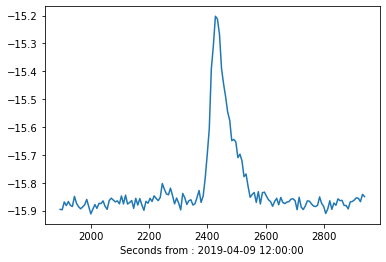

In [152]:
arr_x = np.log10(rebin_data_all[idx_range,57])
N_arr_x=arr_x.ravel().shape[0]
idx_x = np.arange(N_arr_x)
x0 = rebin_t_all[idx_range]

ratio_x = 0.7
plt.plot(x0,arr_x)
plt.xlabel('Seconds from : '+str(dt_anchor))


In [153]:

x_dist=np.partition(arr_x,int(ratio_x*N_arr_x))[:int(ratio_x*N_arr_x)]
avg_d = np.mean(x_dist)
arr_x =arr_x - avg_d

var_d = np.std(x_dist)

cursor_prev = idx_x[
    np.where(arr_x[0:np.argmax(arr_x)]<var_d*3)][-1]
idx_fit=idx_x[(cursor_prev-1):(cursor_prev+3)]
fit_parm = np.polyfit(x0[idx_fit],arr_x[idx_fit],1)
x_get_this = -fit_parm[1]/fit_parm[0] 


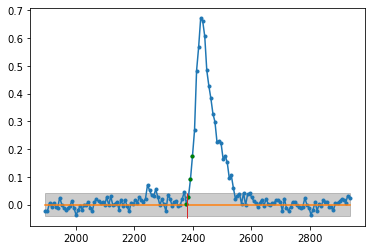

In [154]:
plt.plot(x0, arr_x,'.-')
ax=plt.gca()
ax.plot([x0[0],x0[-1]],[0,0])
ax.fill_between([x0[0],x0[-1]],
   -3*var_d,+3*var_d,color='k',alpha=0.2)
ax.plot(x0[idx_fit], arr_x[idx_fit],'g.')
ax.plot(x_get_this,0,'C3|',zorder=100,markersize=25)



In [144]:
selected_idx = np.arange(42,145,4)
leading_edge = np.zeros(selected_idx.shape)
for i_n,idx in enumerate(selected_idx) :
    freq_this =  rebin_freq_all[idx]
    arr_this = np.log10(rebin_data_all[idx_range,idx])
    leading_edge[i_n] = SEMP.findLeadingPoint(x0,arr_this,ratio_x=0.8)

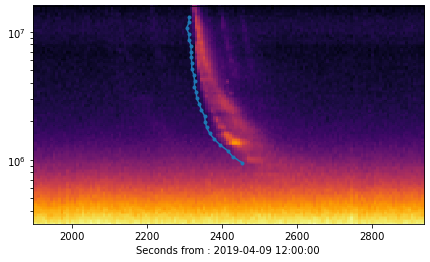

In [145]:

from matplotlib.image import NonUniformImage
fig, ax = plt.subplots(figsize=(7,4))  
#plt.pcolormesh(x0,freqsh34,np.log10(datah34[idx_range,:].T),shading='auto')
im = NonUniformImage(ax, interpolation='nearest',extent=[x0[0],x0[-1],rebin_freq_all[0],rebin_freq_all[-1]],cmap='inferno')
lin_freq = np.linspace(rebin_freq_all[0],rebin_freq_all[-1],rebin_freq_all.shape[0])
im.set_data(x0,lin_freq,np.log10(rebin_data_all[idx_range,:].T))
ax.images.append(im)
ax.set_yscale('log')
ax.set_xlim([x0[0],x0[-1]])
ax.set_ylim([rebin_freq_all[0],rebin_freq_all[-1]])
ax.set_aspect('auto', 'datalim')
ax.set_xlabel('Seconds from : '+str(dt_anchor))
ax.plot(leading_edge,rebin_freq_all[selected_idx],'C0.-')
ax.yaxis.set_major_locator(plt.LogLocator(base=10,subs='all'))

In [89]:
rebin_freq_all

array([  316227.76601684,   324645.50642658,   333287.32062498,
         342159.17328428,   351267.18785175,   360617.65077612,
         370217.01584657,   380071.90864716,   390189.13112995,
         400575.66630973,   411238.68308378,   422185.54117992,
         433423.79623628,   444961.20501629,   456805.73076244,
         468965.54869266,   481449.05164286,   494264.85585986,
         507421.80694829,   520928.98597605,   534795.71574204,
         549031.56721095,   563646.36611919,   578650.19975673,
         594053.42392947,   609866.67010689,   626100.85276004,
         642767.17689483,   659877.14578579,   677442.56891582,
         695475.57012717,   713988.59598949,   732994.42439052,
         752506.17335561,   772537.31010185,   793101.66033331,
         814213.41778369,   835887.15401301,   858137.82846501,
         880980.79879235,   904431.8314566 ,   928507.11261047,
         953223.25926959,   978597.33078182,  1004646.84060176,
        1031389.76837872,  1058844.57236

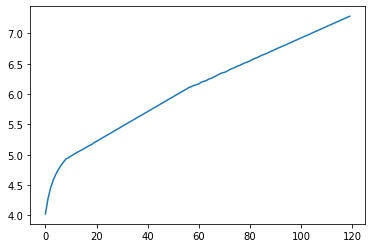

In [51]:

plt.plot(np.log10(np.concatenate((freqsl12[0:56],freqsh34))))

In [102]:
np.where(freqsl12>freqsh34[0])[0]

array([57, 58, 59, 60, 61, 62, 63], dtype=int64)